# Two body system

Consider a system of two bodies under gravitational attraction. The masses are $m_1,m_2$ and the gravitational constant is $\mathcal{G}$.

The generalised coordinates of the system are the polar coordinates $r,\theta$ of the body of mass $m_1$ in the reference frame centred on the centre of gravity $O$ of the two bodies ($O$ itself has a rectilinear uniform motion). The standard (Cartesian) coordinates are then given by

\begin{equation*}
x = r\cos\theta
\hspace{2cm}
y = r\sin\theta
\end{equation*}

By construction, the polar coordinates of the other body are $\frac{m_1}{m_2}r,-\theta$, and the distance between the two bodies is therefore given by $r(1+\frac{m_1}{m_2})$. Hence, the gravitational force exerted on $m_1$ (by $m_2$) is

\begin{equation*}
F = -\mathcal{G}\frac{m_1m_2}{(1+\frac{m_1}{m_2})^2r^2}
\left(\begin{array}{l}\cos\theta\\ \sin\theta\end{array}\right) = -\nabla V
\hspace{1cm}\textrm{with}\hspace{1cm}
V \triangleq -\mathcal{G}\frac{m_1m_2}{(1+\frac{m_1}{m_2})^2}\frac{1}{r}
\end{equation*}

Hence the Lagrangian

\begin{equation*}
\mathcal{L} = m_1(\frac{1}{2}(\dot{r}^2+r^2\dot{\theta}^2)+\frac{a}{r})
\hspace{1cm}\textrm{with}\hspace{1cm}
a \triangleq \frac{\mathcal{G}m_2}{(1+\frac{m_1}{m_2})^2}
\end{equation*}

Introducing the intermediary variable $\lambda=r^2\dot{\theta}$ (angular momentum), the equations of the dynamics are given by:

\begin{equation*}
\left\{
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\dot{\theta} & = & \frac{\lambda}{r^2}\\
& \dot{\lambda} & = & 0\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{r}} = \frac{\partial\mathcal{L}}{\partial r}\right]
\hspace{1cm} &
\ddot{r} & = & \frac{\lambda^2}{r^3}-\frac{a}{r^2}
\end{array}
\right.
\end{equation*}

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from ipyshow.util import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## G2body class

In [2]:
#----------------------------------------------------------------------------------------------------
class G2body (System):
#----------------------------------------------------------------------------------------------------

  shadowshape = (4,)

  @Setup(
      'M1,M2: mass of the bodies [kg]',
      'G: gravitational constant [m^3.kg^-1.sec^-2]',
  )
  def __init__(self,M1,M2,G):
    self.M1,self.M2,self.G = M1, M2, G
    self.a = G*M2/square(1+M1/M2)
    def main(t,state,a=self.a):
      r,θ,rʹ,λ = state
      r2 = square(r)
      θʹ = λ/r2
      rʺ = (square(λ)/r-a)/r2
      λʹ = 0.
      return array((rʹ,θʹ,rʺ,λʹ))
    self.main = main
    def jac(t,state,a=self.a):
      r,θ,rʹ,λ = state
      r2 = square(r)
      r3 = r*r2
      return array((
        (0,0,1,0),
        (-2*λ/r3,0,0,1/r2),
        ((-3*square(λ)/r+2*a)/r3,0,0,2*λ/r3),
        (0,0,0,0),
        ))
    self.jacobian = jac
    def fordisplay(state,t=M1/M2):
      r,θ,rʹ,λ = state
      x,y = r*cos(θ),r*sin(θ)
      live = x,y,-t*x,-t*y
      return live, live
    self.fordisplay = fordisplay

  def display(self,ax,refsize=100.,ini=None,**ka):
    m1,m2 = self.M1,self.M2
    ratio = clip(sqrt(m1/m2),1./refsize,refsize)
    sz = (refsize*ratio,refsize/ratio)
    diag_l, = ax.plot((),(),'k',ls=':')
    diag_s = ax.scatter((0,0),(0,0),s=sz,marker='o',c=('r','b'))
    tail_l = ax.plot((),(),'r',(),(),'b')
    p,e,φ,E,λ = self.analytics(ini)
    if abs(1-e)<1e-10:
      conic = 'Parabola'
      def resize(x,y):
        ax.relim()
        ax.autoscale_view()
    elif e<1:
      from matplotlib.patches import Ellipse
      u = 1-square(e)
      A,B = p/u,p/sqrt(u)
      c = -e*A*array((cos(φ),sin(φ)))
      T = 2*pi*A*B/λ
      conic = 'Ellipse($e$={:.2f}) period:{:.2f}'.format(e,T)
      ax.add_patch(Ellipse(c,2*A,2*B,φ/pi*180,lw=1,color='k',fill=False,ls='dashed'))
      rmax = 1.1*p/(1-e)
      if m2<m1: rmax *= m1/m2
      ax.set_xlim(-rmax,rmax)
      ax.set_ylim(-rmax,rmax)
      resize = (lambda x,y: None)
    else:
      c = e*p/(square(e)-1)*array((cos(φ),sin(φ)))
      φₒ = arccos(-1/e)
      asymp_l, = ax.plot((),(),'k',ls='--')
      conic = 'Hyperbola($e$={:.2f})'.format(e)
      def resize(x,y,cx=c[0],cy=c[1],a00=sin(φ-φₒ),a01=cos(φ-φₒ),a10=sin(φ+φₒ),a11=cos(φ+φₒ)):
        xc = x-cx; yc = y-cy
        d = xc*a00-yc*a01,xc*a10-yc*a11,
        d,a0,a1 = (d[0],a00,a01) if abs(d[1])>abs(d[0]) else (d[1],a10,a11)
        asymp_l.set_data((c[0],x-d*a0),(c[1],y+d*a1))
        ax.relim()
        ax.autoscale_view()
    ax.set_title('trajectory: {}'.format(conic))
    def disp(t,live,tail):
      x1,y1,x2,y2 = live
      diag_l.set_data((x1,x2),(y1,y2))
      diag_s.set_offsets(((x1,y1),(x2,y2)))
      tail_l[0].set_data(tail[:,0],tail[:,1])
      tail_l[1].set_data(tail[:,2],tail[:,3])
      resize(x1,y1)
    return super().display(ax,disp,ini=ini,**ka)

  def analytics(self,ini):
    r,θ,rʹ,λ = ini
    E = square(rʹ)+square(λ/r)-2*self.a/r
    p = square(λ)/self.a
    e = sqrt(1+E*p/self.a)
    φ = arcsin(rʹ*λ/(self.a*e))
    if p<r: φ=pi-φ
    φ = θ-φ
    return p,e,φ,E,λ

  @staticmethod
  @Setup(
    'r: distance of 1st body from centre of gravity [m]',
    'θ: angle of axis between the two bodies with reference [deg]',
    'rʹ: speed of 1st body towards (or away from) centre of gravity [m.sec^-1]',
    'θʹ: angular speed [deg.sec^-1]',
    θ=0.,rʹ=0.,θʹ=0.)
  def makestate(r,θ,rʹ,θʹ): return array((r,radians(θ),rʹ,square(r)*radians(θʹ)))

  @Setup(
    System.launch,
    'refsize: average size (area) of the bodies for display [pt^2]',
    taild=10.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [3]:
Setup.display(G2body)

**** G2body.__init__(self, M1, M2, G) ****
    M1,M2     : mass of the bodies [kg]
    G         : gravitational constant [m^3.kg^-1.sec^-2]
**** G2body.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (10.0      ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
    refsize   : average size (area) of the bodies for display [pt^2]
**** G2body.makestate(r, θ, rʹ, θʹ) ****
    r         : distance of 1st body from centre of gravity [m]
    θ         (0.0       ): angle of axis between the two bodies with reference [deg]
    rʹ        (0.0       ): speed of 1st body towards (or away from) centre of gravity [m.sec^-1]
    θʹ        (0.0       ): angular speed [deg.sec^-1]

<IPython.core.display.Javascript object>


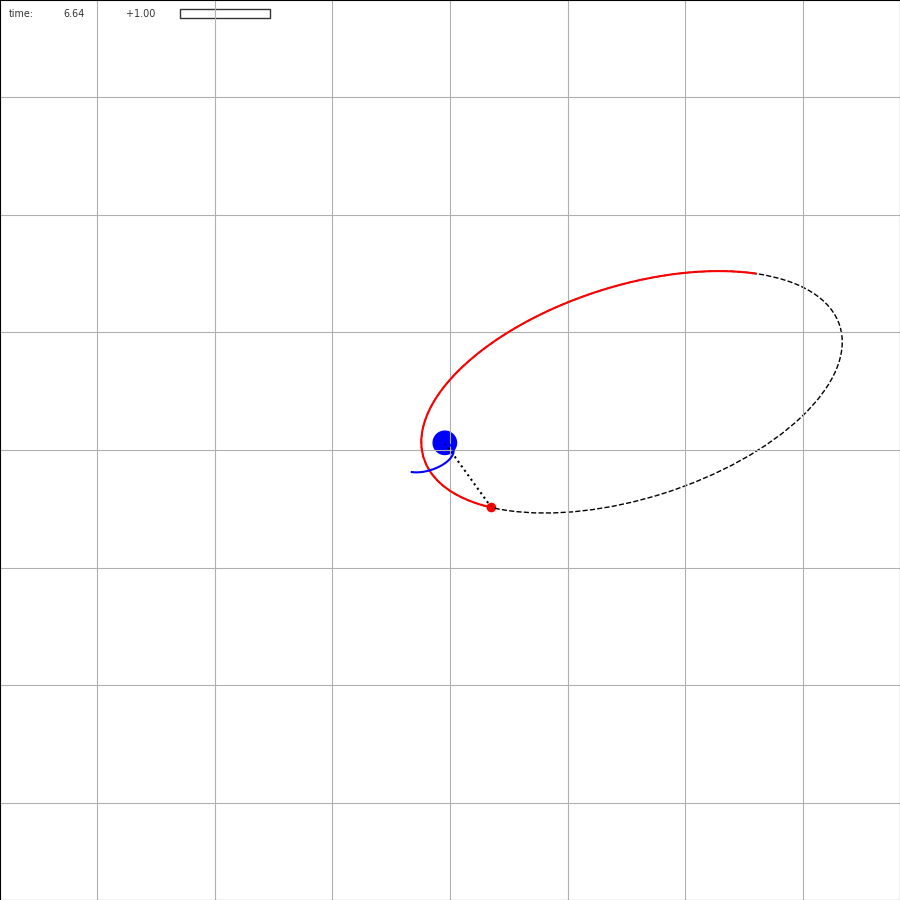

In [4]:
logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook
syst = G2body(G=1,M1=10,M2=80)
#syst = G2body(G=1,M1=10,M2=10)
ini = dict(r=15.,rʹ=-1.,θ=30.,θʹ=3.)
syst.launch(ini=syst.makestate(**ini))

Trajectory
----------

The law of conservation of energy yields $\dot{r}^2=E-\frac{\lambda^2}{r^2}+\frac{2a}{r}$ for some constant $E$ (total energy) and, using $\dot{\theta}=\frac{\lambda}{r^2}$ and $\frac{\mathbf{d}r}{\mathbf{d}\theta}=\frac{\dot{r}}{\dot{\theta}}$, one gets

\begin{equation*}
(\frac{\mathbf{d}r}{\mathbf{d}\theta})^2 = r^2(\frac{E}{\lambda^2}r^2+2\frac{a}{\lambda^2}r-1)
\hspace{1cm}
\textrm{with initial conditions}
\hspace{1cm}
r|_{\theta_0} = r_0
\textrm{ and }
\frac{\mathbf{d}r}{\mathbf{d}\theta}|_{\theta_0}=\frac{\dot{r}_0r_0^2}{\lambda}
\end{equation*}

One solution is given by

\begin{equation*}
r = \frac{p}{1+e\cos(\theta-\phi)}
\hspace{1cm}\textrm{with}\hspace{1cm}
p\triangleq\frac{\lambda^2}{a}
\textrm{ and }
e\triangleq\sqrt{1+\frac{E\lambda^2}{a^2}}
\textrm{ and }
\left|
\begin{array}{l}
\sin(\theta_0-\phi)\triangleq\frac{\lambda\dot{r}_0}{ae}\\
\cos(\theta_0-\phi)\triangleq\frac{p-r_0}{er_0}
\end{array}
\right.
\end{equation*}

The presence of two (consistent) initial conditions compensate for the unknown sign of  $\frac{\mathbf{d}r}{\mathbf{d}\theta}$, so that the system is deterministic (unique solution), hence the trajectory above is the only possible one. It is a conic section (ellipse if $e\lt1$, parabola if $e=1$, hyperbola if $e\gt1$) with the origin $O$ as focus. The initial conditions define the values of $\lambda,E$, and hence those of $p,e,\phi$ (by construction, the equations defining $\phi$ have a unique solution modulo $2\pi$). 

Periodicity
-----------

In the case of an ellipse, the motion is periodic and the period is given by

\begin{equation*}
T = \int_0^{2\pi}\frac{r^2}{\lambda}\mathbf{d}\theta=\frac{\mathcal{2A}}{\lambda}
\end{equation*}

where $\mathcal{A}$ is the area of the ellipse. Using the change of variable $t=\tan\frac{\theta}{2}$:

\begin{equation*}
\mathcal{A} = \int_0^{2\pi}\frac{p^2}{2(1+e\cos\theta)^2}\mathbf{d}\theta =
\int_0^{\pi}\frac{p^2}{(1+e\cos\theta)^2}\mathbf{d}\theta =
2p^2\int_0^\infty\frac{\mathbf{d}t}{(1+t^2)(1+e\frac{1-t^2}{1+t^2})^2}
\end{equation*}

Simplifying the algebraic fraction in the integrand, we get

\begin{equation*}
\mathcal{A} = \frac{2p^2}{(1-e)^2}\int_0^\infty\frac{1+t^2}{(c+t^2)^2}\mathbf{d}t
\hspace{1cm}\textrm{with}\hspace{1cm}
c\triangleq\frac{1+e}{1-e}
\end{equation*}

Now, the integrand can be rewritten as

\begin{equation*}
\frac{1+t^2}{(c+t^2)^2} = \frac{1-c}{2c}\frac{c-t^2}{(c+t^2)^2}+\frac{1+c}{2c}\frac{1}{c+t^2}\\
\textrm{where } \int_0^\infty\frac{c-t^2}{(c+t^2)^2}\mathbf{d}t=[\frac{t}{c+t^2}]_0^\infty=0\\
\textrm{and } \int_0^\infty\frac{1}{c+t^2}\mathbf{d}t=\frac{1}{\sqrt{c}}\int_0^\infty\frac{\mathbf{d}t}{1+t^2}=\frac{1}{\sqrt{c}}[\arctan t]_0^\infty=\frac{\pi}{2\sqrt{c}}
\end{equation*}

Hence we have $\int_0^\infty\frac{1+t^2}{(c+t^2)^2}\mathbf{d}t=\frac{\pi(1+c)}{4c\sqrt{c}}$. Reporting in $\mathcal{A}$ and simplifying, we get

\begin{equation*}
\mathcal{A} = \pi p^2 (1-e^2)^{-\frac{3}{2}}
\end{equation*}